In [1]:
# Script saves QBO metrics for EKI
import os
import glob
import csv
import argparse

import numpy as np
import netCDF4 as nc
import matplotlib.pyplot as plt

# Add directories to path
import sys
sys.path.insert(0, "../py_qbo_metrics/")

from get_QBO_TT_metrics import get_QBO_periods_amplitudes
from mean_lat_weighted import mean_lat_weighted
from scipy.interpolate import InterpolatedUnivariateSpline


## Plot the QBO for a given MiMA simulation
Plot wind speeds at 10 hPa at the equator - lets us check for QBO properties (period, amplitude) and whether there are any disruptions

In [16]:
# User choice: what iteration and run id to plot
iteration = 2
run_num = 41


In [35]:
basedir = os.environ['SCRATCH']+f"/EKI/iteration_{iteration}/"
rundir = basedir + f"{run_num:02d}/"

print("Reading atmos_daily_*.nc files from ", rundir)

# We need to concatenate years 20-40
# Get first run
filename = 'atmos_daily_0'
try:
    dataset = nc.Dataset(rundir+filename+'.nc', 'r')
except IOError as e:
    print(e)

time = dataset['time']
pfull = dataset['pfull']
ucomp = dataset['ucomp']
lat = dataset['lat']
# Calc the zonal mean zonal winds at 10 hPa between 5 deg S and 5 deg N
u_mean10 = mean_lat_weighted( ucomp[:, 13, 30:34, :].mean(axis=(-1)), lat[30:34], axis=(-1) )

for i in range(1, 20):
    filename = f"atmos_daily_{i}"
    try:
        dataset = nc.Dataset(rundir+filename+'.nc', 'r')
    except IOError as e:
        print(e)
    ucomp = dataset['ucomp']

    # Calc the zonal mean zonal winds at 10 hPa between 5 deg S and 5 deg N
    u_mean10_new = mean_lat_weighted( ucomp[:, 13, 30:34, :].mean(axis=(-1)), lat[30:34], axis=(-1) )

    # Concatenate 
    u_mean10 = np.concatenate((u_mean10, u_mean10_new), axis=0)
    time = np.concatenate((time, dataset['time']), axis=0)



Reading atmos_daily_*.nc files from  /scratch/users/lauraman/EKI/iteration_2/41/


In [36]:
# Get QBO periods and amplitudes. Daily data so the smoothing scale is 30 * 5 months  = 150 days
periods, amplitudes = get_QBO_periods_amplitudes(u_mean10, N_smooth=150)
periods = periods / 30
print(periods, amplitudes)

900
[ 256  511 1031 1275 1944 2167 2809 3049 3772 4051 4625 4949 5541 5712
 6328 6499 7103]
[25.84511559 30.42491415 28.84907168 32.08988193 28.42329613 30.55240611
 26.22142999 25.84666555] [34.762664794921875, 27.453022003173828, 33.27679443359375, 31.184789657592773, 26.644187927246094, 26.850080490112305, 28.713632583618164, 27.022388458251953]


In [37]:
period_mean = np.array(periods).mean()
amplitude_mean = np.array(amplitudes).mean()
cov = np.cov(periods, amplitudes)
print(cov)

[[ 5.74359158 -1.05663838]
 [-1.05663838 10.1317218 ]]


In [38]:
info = (f"Period: {period_mean:.2f} ({np.sqrt(cov[0,0]):.2f}) months \nAmplitude: {amplitude_mean:.2f} ({np.sqrt(cov[1,1]):.2f}) m/s")
print(info)


Period: 28.53 (2.40) months 
Amplitude: 29.49 (3.18) m/s


In [39]:
# First we smooth with a 5 month binomial smoothing
N_smooth = 150
u_smoothed = np.convolve(u_mean10, np.ones(N_smooth), mode='same')/N_smooth


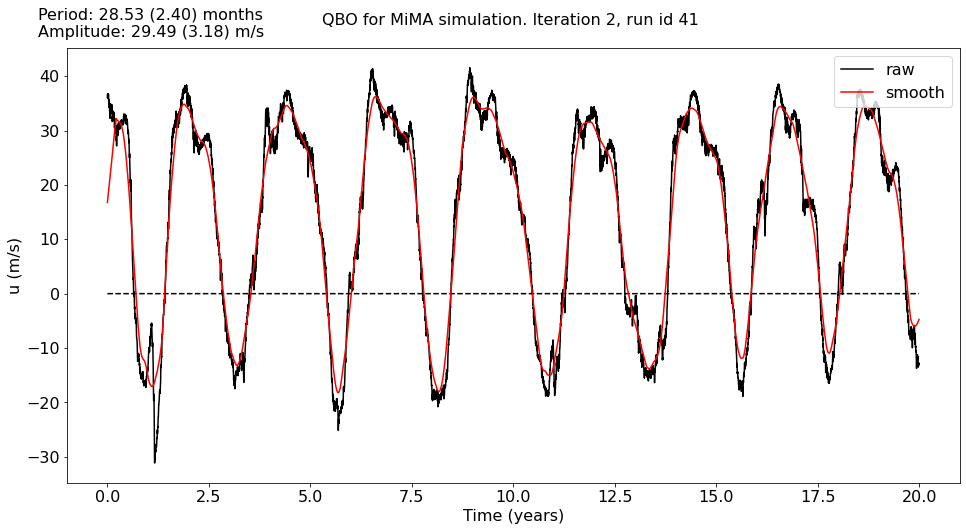

In [40]:
fig = plt.figure(figsize=(16, 8))
plt.plot((time-time[0])/360., np.zeros(len(time)), "k--")
plt.plot((time-time[0])/360., u_mean10, label="raw", color="black")
plt.plot((time-time[0])/360., u_smoothed, label="smooth", color="red")
plt.title(f"QBO for MiMA simulation. Iteration {iteration}, run id {run_num} \n ", fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.ylabel("u (m/s)", fontsize=16)
plt.xlabel("Time (years)", fontsize=16)
plt.text(0.1, 0.9, info, transform=fig.transFigure, fontsize=16)
plt.legend(loc="upper right", fontsize=16)


